# Load Libraries, Data, Tokenizer
We will use HuggingFace transformers [here][1]

[1]: https://huggingface.co/transformers/

In [ ]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

In [ ]:
from tokenizers import BertWordPieceTokenizer

PATH = '../input/bert-pretrained-models/null'
# tokenizer = tokenizers.ByteLevelBPETokenizer(
#     vocab_file=PATH+'vocab-roberta-base.json', 
#     merges_file=PATH+'merges-roberta-base.txt', 
#     lowercase=True,
#     add_prefix_space=True
# )

#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer = BertWordPieceTokenizer('../input/bert-pretrained-models/uncased_L-24_H-1024_A-16/uncased_L-24_H-1024_A-16/vocab.txt', lowercase=True)

sentiment_id = {'positive': 3893, 'negative': 4997, 'neutral': 8699} # changed to bert tokens
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

In [ ]:
tokenizer.encode('neutral').ids

In [ ]:
PATH

# Training Data
We will now convert the training data into arrays that roBERTa understands. Here are example inputs and targets: 
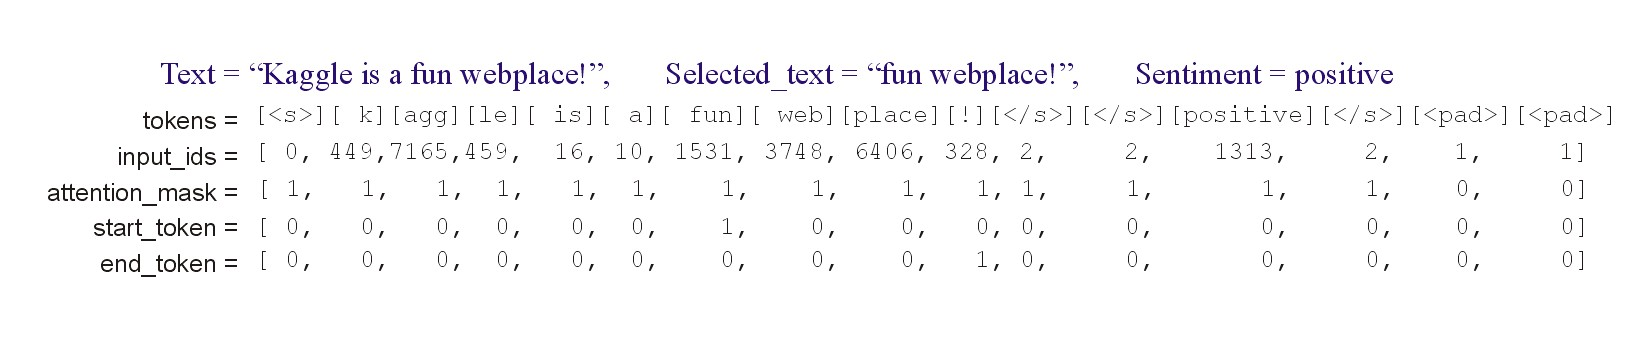
The tokenization logic below is inspired by Abhishek's PyTorch notebook [here][1].

[1]: https://www.kaggle.com/abhishek/roberta-inference-5-folds

In [ ]:
from tokenizers import decoders

tokenizer.decoder = decoders.WordPiece()

tokenizer.encode('http://twitpic.com/67fue - My formerly pretty car')
tokenizer.decode(tokenizer.encode('http://twitpic.com/67fue - My formerly pretty car').ids, skip_special_tokens=True)

In [ ]:
enc = tokenizer.encode('http://twitpic.com/67fue - My formerly pretty car')
input_ids_orig, offsets = enc.ids, enc.offsets

def no_whitespace(s,offsets): # gets rid of whitespace that happens when reversing tokenization
    #s_offs = tokenizer.encode(s).offsets
    s_offs = offsets
    decoded_s  = ""
    for i in range(len(s_offs)):
        decoded_s += s[s_offs[i][0]: s_offs[i][1]]
        if (i+1) < len(s_offs) and s_offs[i][1] < s_offs[i+1][0]:
            decoded_s += " "
    return decoded_s

def decode(pred_start, pred_end, text, offset):

    decoded_text = ""
    for i in range(pred_start, pred_end):
        decoded_text += text[offset[i][0]:offset[i][1]]
        if (i+1) < len(offset) and offset[i][1] < offset[i+1][0]:
            decoded_text += " "
    return decoded_text

In [ ]:
MAX_LEN = 128

ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split()) # split then separate all words by a single space and add space before joined string
    text2 = " ".join(train.loc[k,'selected_text'].split()) # split and join, no beginning space
    idx = text1.find(text2) # returns starting index of selected text in text, returns 1 because 0 is space in text1
    chars = np.zeros((len(text1))) # initiate vector representation of text1
    chars[idx:idx+len(text2)]=1 # vector now has "1" in indices of "text1" where "text2"(selected_tect) words are found
    if text1[idx-1]==' ': chars[idx-1] = 1 # if space before text1(which should be true) make =1
    enc = tokenizer.encode(text1)
        
    # ID_OFFSETS
    offsets = []; idx=0 #reuse idx variable
    for t in enc.ids: # iterate through encoded vocabulary of a single tweet
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w))) # (index in offset of start of tokenizer char, index of the end of decoded tokenized character)
        idx += len(w) # set up next enc, dec pair -- *works because [a:b] does not include b in start end tokens block
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b]) # excludes b
        if sm>0: toks.append(i) # any part of selected_text that overlaps text will return 1 and that tuple will be added as tokens shared
        
    s_tok = sentiment_id[train.loc[k,'sentiment']] # retrieve sentiment token
    #input_ids[k,:len(enc)+5] = [0] + enc + [2,2] + [s_tok] + [2] # populates input_ids tag of k tweet 2 and 0 are spaces, +5 for initial space, s/s/ sent,space   
    input_ids[k,:len(enc.ids)+5] = [2] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1 
        end_tokens[k,toks[-1]+1] = 1

In [ ]:
enc

# Test Data
We must tokenize the test data exactly the same as we tokenize the training data

In [ ]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [2] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    #config = BertConfig.from_pretrained('../input/bert-pretrained-models/multi_cased_L-12_H-768_A-12/multi_cased_L-12_H-768_A-12/bert_config.json')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    
#    x1 = tf.keras.layers.Concatenate(axis=-1)([x[-1], x[-2]])
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) # start token indices
#    x1 = tf.keras.layers.Conv1D(1,1)(x1) # changed from 1,1
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
#    x1 = tf.keras.layers.Dropout(0.1)(x[0])
    x1 = tf.keras.layers.Activation('softmax')(x1)

#    x2 = tf.keras.layers.Concatenate(axis=-1)([x[-1], x[-2]])
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
#    x2 = tf.keras.layers.Conv1D(1,1)(x2) # changed from 1,1
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
#    x2 = tf.keras.layers.Dropout(0.1)(x[0])
    x2 = tf.keras.layers.Activation('softmax')(x2) # end token indices

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [ ]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# x = bert_model(ids,attention_mask=att,token_type_ids=tok)
# x
model = build_model()
model.load_weights('../input/tensorflow-bert-samir/v0-bert-4.h5')
model.config()

# Metric

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#model.load_weights('../input/distilbert-05/v0-bert-1.h5')

In [ ]:
#model.summary()

# Train roBERTa Model
We train with 5 Stratified KFolds (based on sentiment stratification). Each fold, the best model weights are saved and then reloaded before oof prediction and test prediction. Therefore you can run this code offline and upload your 5 fold models to a private Kaggle dataset. Then run this notebook and comment out the line `model.fit()`. Instead your notebook will load your model weights from offline training in the line `model.load_weights()`. Update this to have the correct path. Also make sure you change the KFold seed below to match your offline training. Then this notebook will proceed to use your offline models to predict oof and predict test.

In [ ]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777) #changed folds from 5
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-bert-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
         save_weights_only=True, mode='auto', save_freq='epoch')
   
#      if fold == n_splits -1:
#          log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#          tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#     log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        
#     sv = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # comment out when testing trained model
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=64, verbose=DISPLAY, callbacks=[sv],#can change batch from 32 and epochs from 3
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    #model.load_weights('../input/distilbert-05/v0-bert-1.h5') # changed fold USE THIS WHEN TESTING
    model.load_weights('%s-bert-%i.h5'%(VER,fold)) # changed fold USE THIS WHEN TRAINING
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            #enc = tokenizer.encode(text1)
            #st = tokenizer.decode(enc.ids[a-1:b])
            #st = no_whitespace(text1)
            
            #get ride of whitespaces
            #offsets = []; idx=1 #reuse idx variable and calculate offsets
            enc = tokenizer.encode(text1)
#             for t in enc: # iterate through encoded vocabulary of a single tweet
#                 w = tokenizer.decode([t])
#                 offsets.append((idx,idx+len(w))) # (index in offset of start of tokenizer char, index of the end of decoded tokenized character)
#                 idx += len(w)
            
            st = decode(a-1,b,text1, enc.offsets)
            
            
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

In [ ]:
model.summary()

In [ ]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

# Kaggle Submission

In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        #st = tokenizer.decode(enc.ids[a-1:b])
        offsets = []; idx=1 #reuse idx variable and calculate offsets
        enc = tokenizer.encode(text1).ids[a-1:b]
        for t in enc: # iterate through encoded vocabulary of a single tweet
            w = tokenizer.decode([t])
            offsets.append((idx,idx+len(w))) # (index in offset of start of tokenizer char, index of the end of decoded tokenized character)
            idx += len(w)
            
        #get ride of whitespaces
        #offsets = []; idx=1 #reuse idx variable and calculate offsets
        
        enc = tokenizer.encode(text1)            
        st = decode(a-1,b,text1, enc.offsets)
    all.append(st)

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)